# Custom Implementation of Semantic Segmentation

In [1]:
from torchvision.datasets import Cityscapes

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np

import torch
import torch.nn as nn

In [2]:
data_path = 'HRNet/data/cityscapes'

In [3]:
dataset = Cityscapes(data_path, split='train', mode='fine', target_type='semantic')

In [4]:
dataset[0][0].size

(2048, 1024)

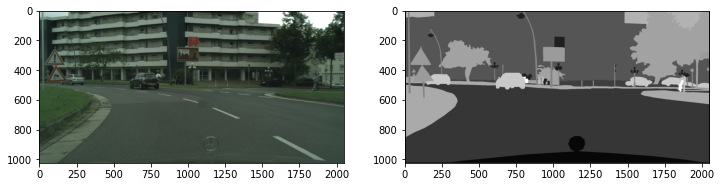

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1], cmap='gray')

In [6]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', \
              'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
              'train', 'motorcycle', 'bicycle']

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [7]:
colors = [ [0,  0,  0],
          [128, 64,128],
          [244, 35,232],
          [70, 70, 70],
          [102,102,156],
          [190,153,153],
          [153,153,153],
          [250,170, 30],
          [250,170, 30],
          [107,142, 35],
          [152,251,152],
          [ 70,130,180],
          [220, 20, 60],
          [255,  0,  0],
          [ 0,  0,142],
          [  0,  0, 70],
          [  0,  0, 70],
          [  0, 80,100],
          [  0,  0,230],
          [119, 11, 32] ]

label_colors = dict(zip(range(n_classes), colors))

In [8]:
def encode_segmap(mask):
    for i in valid_classes:
        mask=mask[mask==i]
    return mask

In [9]:
def encode_segmap(mask):
    #remove unwanted classes and rectify  the labels of wanted classes
    for _voidc in void_classes:
        mask[mask==_voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask==_validc]=class_map[_validc]
    return mask

In [10]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colors[l][0]
        g[temp == l] = label_colors[l][1]
        b[temp == l] = label_colors[l][2]
    
    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb 
        

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform=A.Compose(
    [
        A.Resize(256, 512),
        A.HorizontalFlip(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225) ),
        ToTensorV2(),
    ]
)

In [12]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class CustomDataset(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')
        
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            
            if self.transforms is None:
                raise ValueError("This custom dataset should have transforms. Otherwise please use Pytorch's Cityscapes class.")
            transformed= transform(image=np.array(image), mask=np.array(target))
            return transformed['image'], transformed['mask']

In [13]:
data_path = 'HRNet/data/cityscapes'

In [14]:
dataset = CustomDataset(data_path, split='val', mode='fine', target_type="semantic", transforms=transform)
img, seg = dataset[20]
print(img.shape, seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


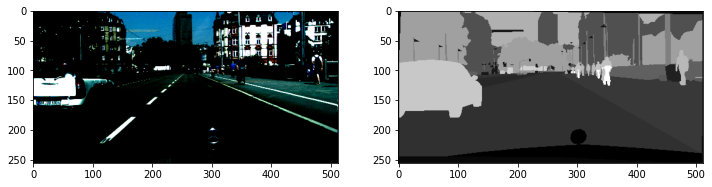

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg, cmap='gray')

In [16]:
# class labels before label correction
print(torch.unique(seg),len(torch.unique(seg)))

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 17, 18, 20, 21, 23, 24, 25,
        26, 27, 33], dtype=torch.uint8) 21


In [17]:
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res),len(torch.unique(res)))

torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 11, 12, 13, 14, 15, 19],
       dtype=torch.uint8) 15


In [18]:
# with coloring
res1=decode_segmap(res.clone())

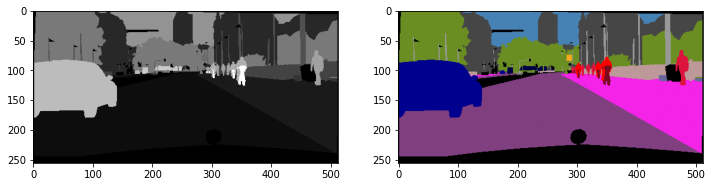

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].imshow(res, cmap='gray')
ax[1].imshow(res1, cmap='gray')

## Training with Cityscapes

In [20]:
from torch.utils.data import DataLoader, Dataset
import torchmetrics

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning import seed_everything, LightningModule, Trainer

import segmentation_models_pytorch as smp

import multiprocessing

In [21]:
class CityUNet(LightningModule):
    
    def __init__(self):
        super(CityUNet, self).__init__()
        self.layer = smp.Unet(
            encoder_name='resnet34',
            encoder_weights="imagenet",
            in_channels=3,
            classes = n_classes
        )
        
        self.lr=1e-3
        self.batch_size=32
        self.numworkers= multiprocessing.cpu_count()#//4 if multiprocessing.cpu_count()//4 > 0 else 1
        
        self.criterion=smp.losses.DiceLoss(mode='multiclass')
        self.metrics = torchmetrics.IoU(num_classes=n_classes)
        
        self.train_class = CustomDataset(data_path, split='train', mode='fine', target_type='semantic', transforms=transform)
        self.val_class = CustomDataset(data_path, split='val', mode='fine', target_type='semantic', transforms=transform)
        
        
    def process(self, image, segment):
        out = self(image)
        segment = encode_segmap(segment)
        loss = self.criterion(out, segment.long())
        iou = self.metrics(out, segment)
        return loss, iou
    
    def forward(self, x):
        return self.layer(x)
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return opt
    
    def train_dataloader(self):
        print(f'Using {self.numworkers} tasks.')
        return DataLoader(self.train_class, batch_size=self.batch_size, shuffle=True, num_workers=self.numworkers, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_class, batch_size=self.batch_size, shuffle=False, num_workers=self.numworkers, pin_memory=True)
    
    def training_step(self, batch, batch_idx):
        image, segment = batch
        loss, iou = self.process(image, segment)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_iou', loss, on_step=False, on_epoch=True, prog_bar=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        image, segment = batch
        loss, iou = self.process(image, segment)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_iou', loss, on_step=False, on_epoch=True, prog_bar=False)
        return loss

In [22]:
model = CityUNet()

checkpoints_path = 'checkpoints'
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=checkpoints_path, filename='file', save_last=True)

In [23]:
trainer = Trainer(max_epochs=200, 
                 auto_lr_find=False, 
                 auto_scale_batch_size=False,
                 gpus = 1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params
---------------------------------------
0 | layer     | Unet     | 24.4 M
1 | criterion | DiceLoss | 0     
2 | metrics   | IoU      | 0     
---------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.756    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

In [ ]:
import torch
import os

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
diplay(available_gpus, torch.cuda.device_count())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

([<torch.cuda.device at 0x1fc917cc790>], 1)